In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Garbage collector
import gc
gc.enable()

In [3]:
# Import the preprocessed dataframes
train_raw_df = pd.read_csv("preprocessed_train(3).csv",
    dtype={'fullVisitorId': str}, nrows=None)
test_raw_df = pd.read_csv("preprocessed_test(3).csv",
    dtype={'fullVisitorId': str}, nrows=None)
train_raw_df.shape, test_raw_df.shape

((903653, 33), (804684, 32))

In [4]:
train_raw_df.head()

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,39,0,False,21,...,3,59008,0.0,3,33,False,3509,3,3191,206
1,4,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,57,0,False,7,...,3,59008,0.0,3,33,False,3509,3,3191,206
2,4,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,39,0,False,21,...,3,59008,0.0,3,33,False,3509,3,3191,206
3,4,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,115,0,False,6,...,3,59008,0.0,3,33,False,839,3,3191,206
4,4,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,39,1,True,0,...,3,59008,0.0,3,33,True,3509,3,3191,206


### Convert visitStartTime to different data features

In [5]:
def expand_visit_start_time(df):
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour_of_day'] = df['date'].dt.hour
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    # Drop date column
    df.drop(['date'], axis=1, inplace=True)
    return df

##### add here new features

In [6]:
def apply_feature_engineering(df):
    
    df = expand_visit_start_time(df)
    
    
    
    return df

### Checkpoint

In [15]:
train_df = apply_feature_engineering(train_raw_df)
test_df = apply_feature_engineering(test_raw_df)

### Numerical variables conversion

In [11]:
num_features = ['totals.hits', 'totals.pageviews', 'visitNumber', 
                'totals.newVisits']

for col in num_features:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

In [16]:
X = train_df.drop(['totals.transactionRevenue'], axis=1)
y = np.log1p(train_raw_df['totals.transactionRevenue'].values)

### Feature raniking with Random Forest

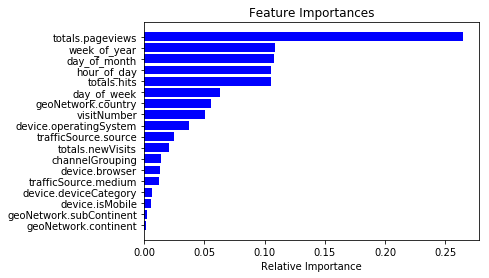

In [33]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs = -1, random_state = seed)
model.fit(temp_df, temp_y)


features = temp_df.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:20])  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Feature ranking with catboost

In [12]:
from catboost import CatBoostRegressor
from catboost import Pool 

#necessary for feature importance ranking
pool = Pool(X, y)


#fit catboost regressor
cat = CatBoostRegressor(
    random_seed = seed,
    loss_function = 'RMSE',
    eval_metric = 'RMSE',
    logging_level='Silent',
    task_type = 'GPU'
)

cat.fit(X, y,
        #cat_features = cat_positions,
        #eval_set = (X_val, y_val),
        #plot = True
       )

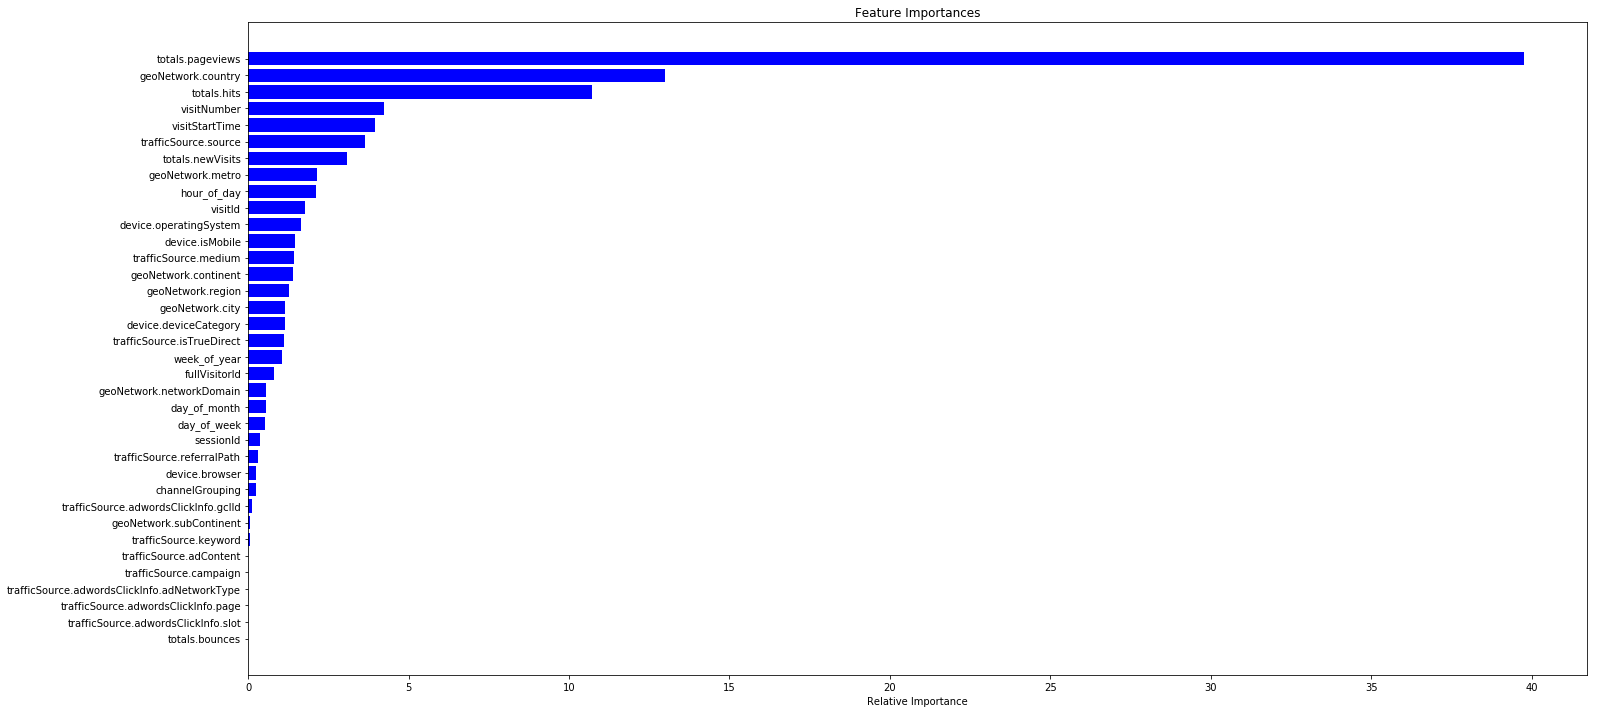

In [17]:
#get importance ranking
features = X.columns
importances = np.asarray(cat.get_feature_importance(pool, fstr_type='FeatureImportance'))
indices = np.argsort(importances)# top features
plt.figure(figsize=(24, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Export Dataframes

In [19]:
train_df.to_csv('featured_train(4).csv', index = False)
test_df.to_csv('featured_test(4).csv', index = False)